# Import requirements

In [1]:
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import sklearn

from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import NAdam
from torcheval.metrics import MulticlassAccuracy
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tqdm.notebook import tqdm



nltk.download('stopwords')
nltk.download('popular')
nltk.download('punkt')
nltk.download('punkt_tab')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\geo

# Check for CUDA

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
print(device)

cuda:0


# Data overview & preprocessing

## Quora dataset

In [3]:
train_quora = pd.read_csv('train.csv').drop('qid', axis=1)
test_quora = pd.read_csv('test.csv').drop('qid', axis=1)

In [4]:
train_quora.head(5)

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


In [5]:
train_quora.drop_duplicates(inplace=True)
train_quora.dropna(inplace=True)
test_quora.drop_duplicates(inplace=True)
test_quora.dropna(inplace=True)

Text(0.5, 1.0, 'Distribution by classes')

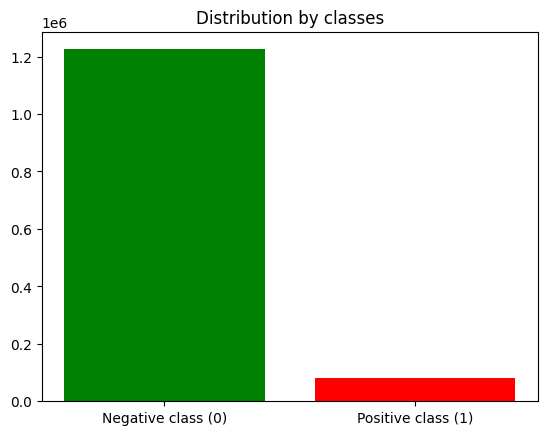

In [6]:
colors = ['green', 'red']
plt.bar(['Negative class (0)', 'Positive class (1)'], train_quora['target'].value_counts(), color=colors)
plt.title('Distribution by classes')

## Jigsaw dataset

In [7]:
train_jigsaw = pd.read_csv('Jigsaw_dataset/train.csv').drop('id', axis=1)
train_jigsaw = train_jigsaw[['target', 'comment_text']]
train_jigsaw = train_jigsaw.rename(columns={'comment_text': 'question_text'})

test_jigsaw = pd.read_csv('Jigsaw_dataset/test.csv').drop('id', axis=1)
test_jigsaw = test_jigsaw.rename(columns={'comment_text': 'question_text'})

In [8]:
train_jigsaw.head(5)

,target,question_text
0,0.000000,"This is so cool. It's like, 'would you want yo..."
1,0.000000,Thank you!! This would make my life a lot less...
2,0.000000,This is such an urgent design problem; kudos t...
3,0.000000,Is this something I'll be able to install on m...
4,0.893617,haha you guys are a bunch of losers.


In [9]:
train_jigsaw.drop_duplicates(inplace=True)
train_jigsaw.dropna(inplace=True)

test_jigsaw.drop_duplicates(inplace=True)
test_jigsaw.dropna(inplace=True)

train_jigsaw['target'] = train_jigsaw['target'].apply(lambda x: 1 if x >= 0.5 else 0)

Text(0.5, 1.0, 'Distribution by classes')

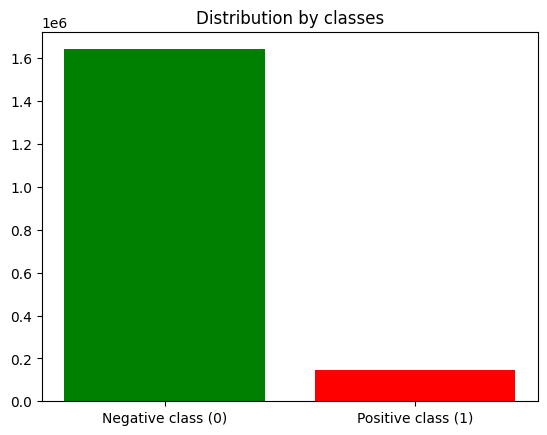

In [10]:
colors = ['green', 'red']
plt.bar(['Negative class (0)', 'Positive class (1)'], train_jigsaw['target'].value_counts(), color=colors)
plt.title('Distribution by classes')

## Combining datasets
stack all negative (target == 0) texts, choose 1M randomly
stack all positive (target >= 0.5) texts, take all of them

In [11]:
train_quora_pos = train_quora[train_quora['target'] == 1]
train_quora_neg = train_quora[train_quora['target'] == 0]

train_jigsaw_pos = train_jigsaw[train_jigsaw['target'] == 1]
train_jigsaw_neg = train_jigsaw[train_jigsaw['target'] == 0]

train_pos = pd.concat([train_quora_pos, train_jigsaw_pos])
train_neg = pd.concat([train_quora_neg, train_jigsaw_neg])
train = pd.concat([train_neg.sample(n=1000000, random_state=1), train_pos]).reset_index().drop('index', axis=1)

test = pd.concat([test_quora, test_jigsaw]).reset_index().drop('index', axis=1)

train.head()

,question_text,target
0,"What are fun, engaging games and activities I ...",0
1,My husband died suddenly and I was left with r...,0
2,"LOL, here you are, just worried about who leak...",0
3,"Gee, that sounds really impressive. Did you ma...",0
4,AWESOME. Made my day.,0


Text(0.5, 1.0, 'Distribution by classes')

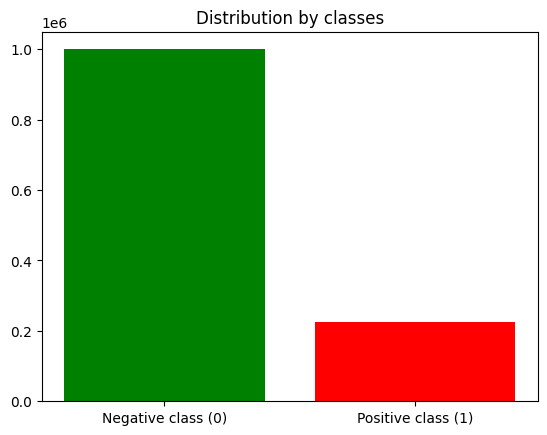

In [12]:
colors = ['green', 'red']
plt.bar(['Negative class (0)', 'Positive class (1)'], train['target'].value_counts(), color=colors)
plt.title('Distribution by classes')

We have a hardly unbalaced classes, so we need to find a way to handle it

## Let's look at distribution by length of the query

In [13]:
def preprocess(df:pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()
    df = df.dropna()
    
    stop_words = set(stopwords.words('english'))

    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_sentence(tokens: list) -> list:
        lemmatized_tokens = []
        for token in tokens:
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
        return lemmatized_tokens

    def remove_stopwords(tokens: list) -> list:
        return [token for token in tokens if token not in stop_words]

    df['question_text'] = df['question_text'].apply(lambda x: x.lower())
    df['question_text'] = df['question_text'].apply(lambda x: tokenizer.tokenize(x))
    df['question_text'] = df['question_text'].apply(lambda x: remove_stopwords(x))
    # df['question_text'] = df['question_text'].apply(lambda x: lemmatize_sentence(x))
        
    return df

train = preprocess(train)
test = preprocess(test)

Mean length in train subset: 18.65891984963119, median length in train subset: 10.0, max length in train subset: 304
Mean length in test subset: 10.76527287652221, median length in test subset: 6.0, max length in test subset: 238


Text(0.5, 1.0, 'length Distribution')

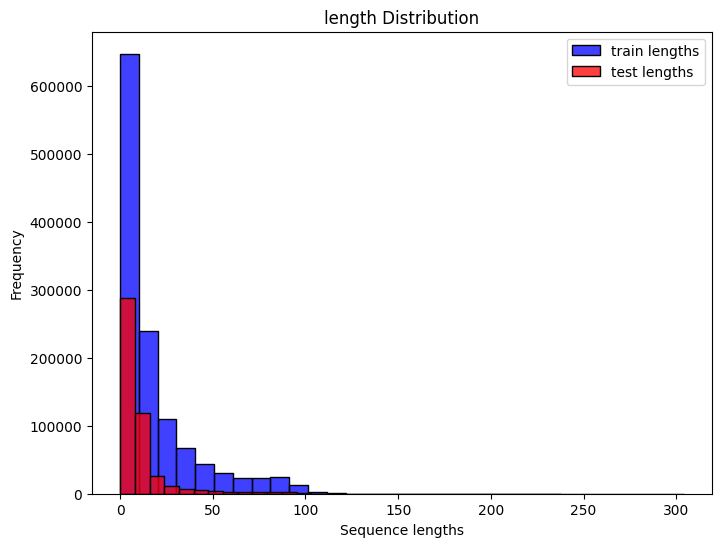

In [14]:
train_seq_lengths = [len(row['question_text']) for _, row in train.iterrows()]
test_seq_lengths = [len(row['question_text']) for _, row in test.iterrows()]
print(f'Mean length in train subset: {np.mean(train_seq_lengths)}, median length in train subset: {np.median(train_seq_lengths)}, max length in train subset: {max(train_seq_lengths)}')
print(f'Mean length in test subset: {np.mean(test_seq_lengths)}, median length in test subset: {np.median(test_seq_lengths)}, max length in test subset: {max(test_seq_lengths)}')

plt.figure(figsize=(8,6))
sns.histplot(train_seq_lengths, color='blue', label='train lengths', kde=False, bins=30)
sns.histplot(test_seq_lengths, color='red', label='test lengths', kde=False, bins=30)
plt.xlabel("Sequence lengths")
plt.ylabel("Frequency")
plt.legend()
plt.title("length Distribution")

## Sequence padding

In [15]:
MAXLEN = 100

def pad_sequences(df: pd.DataFrame, maxlen=50) -> pd.DataFrame:
    df['question_text'] = df['question_text'].apply(lambda x: x[:maxlen])
    df['question_text'] = df['question_text'].apply(lambda x: x + ['<pad>'] * (maxlen - len(x)))
    return df

train = pad_sequences(train, MAXLEN)
test = pad_sequences(test, MAXLEN)

## Making vocab (word -> idx)

In [16]:
def make_vocab():
    unique_words = set()

    for idx, row in train.iterrows():
        unique_words.update(row['question_text'])

    for idx, row in test.iterrows():
        unique_words.update(row['question_text'])
    
    word_to_idx = {'<pad>': 0, '<unk>': 1}
    for idx, word in enumerate(sorted(unique_words), start=2):
        if word != '<pad>' and word != '<unk>':
            word_to_idx[word] = idx

    return word_to_idx, len(word_to_idx) + 1

word_to_idx, vocab_size = make_vocab()

In [17]:
def save_vocab_to_file(filename: str) -> None:
    with open(filename, 'w', encoding='utf8') as vocab:
        for word, idx in word_to_idx.items():
            line = ' '.join([word, str(idx)]) + '\n'
            vocab.write(line)

save_vocab_to_file('vocab.txt')

In [18]:
def read_vocab(vocab_path: str):
            word_to_idx = {}
            with open(vocab_path, 'r', encoding='utf8') as vocab:
                for line in vocab.readlines():
                    word, idx = line.split()
                    word_to_idx[word] = int(idx)
            vocab_size = len(word_to_idx) + 1
            return word_to_idx, vocab_size
word_to_idx, vocab_size = read_vocab('vocab.txt')

## Making GloVe weights matrix

In [19]:
GLOVE_PATH = 'glove.840B.300d.txt'
GLOVE_DIM = 300
def make_weight_matrix(glove_dim: int) -> np.ndarray:
    emb_mean, emb_std = -0.005838499,0.48782197
    weight_matrix = np.zeros((vocab_size, glove_dim))
    glove_dict = {}
    with open(GLOVE_PATH, 'r', encoding="utf8") as glove:
        for line in glove.readlines():
            splitted_line = line.split(' ')
            word = splitted_line[0]
            try:
                vec = np.array(list(map(float, splitted_line[1:])))
            except:
                vec = np.array(list(map(float, splitted_line[2:])))
            glove_dict[word] = vec
            
    for word, idx in word_to_idx.items():
        if word in glove_dict:
            weight_matrix[idx] = glove_dict[word]
        elif word == '<unk>':
            weight_matrix[idx] = np.random.normal(emb_mean, emb_std, glove_dim)
        elif word == '<pad>':
            weight_matrix[idx] = np.zeros(glove_dim)

    return weight_matrix

glove_weights = make_weight_matrix(GLOVE_DIM)

## Converting text to indices

In [20]:
def text_to_idxs(text: list) -> list:
    return [word_to_idx.get(word, word_to_idx['<unk>']) for word in text]

train['question_text'] = train['question_text'].apply(lambda x: text_to_idxs(x))
test['question_text'] = test['question_text'].apply(lambda x: text_to_idxs(x))

## Dataset class

In [21]:
class CombinedDataset:
    def __init__(self, df: pd.DataFrame):
        self.texts = []
        self.labels = []

        for idx, row in df.iterrows():
            indices = row['question_text']
            self.texts.append(indices)
            self.labels.append(row['target'])

        combined = list(zip(self.texts, self.labels))
        random.shuffle(combined)
        self.texts, self.labels = zip(*combined)

        self.texts = torch.stack([torch.tensor(indices, dtype=torch.long) for indices in self.texts])  # [num_samples, seq_len]
        self.labels = torch.tensor(self.labels, dtype=torch.float).unsqueeze(1)  # [num_samples, 1]

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

In [22]:
TRAIN_SIZE = 0.8
BATCH_SIZE = 64

dataset = CombinedDataset(train)
trainset, valset = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE])
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, BATCH_SIZE, shuffle=True)

# Auxiliary

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

# Model class

In [33]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, glove_dim, num_lstm_layers, hidden_size):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, glove_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(glove_dim, hidden_size = hidden_size, num_layers = num_lstm_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        out = self.embedding(x)
        out, (h, c) = self.lstm(out)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.fc2(out)
        return out

model = LSTM_Model(vocab_size, GLOVE_DIM, 3, 256).to(device)

In [25]:
# class LSTMAttention_Model(nn.Module):
#     def __init__(self, vocab_size, glove_dim, num_lstm_layers, hidden_size):
#         super().__init__()
        
#         self.embedding = nn.Embedding(vocab_size, glove_dim)
#         self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
#         self.embedding.weight.requires_grad = False
#         self.lstm = nn.LSTM(glove_dim, hidden_size = hidden_size, num_layers = num_lstm_layers, bidirectional=True, batch_first=True)
#         self.attention = nn.MultiheadAttention(hidden_size * 2, 8, batch_first=True, dropout=0.2)
#         self.fc1 = nn.Linear(hidden_size * 2 , 1)
    
#     def forward(self, x):
#         out = self.embedding(x)
#         out, (h, c) = self.lstm(out)
#         query = out[:, -1, :].unsqueeze(1)
#         key = out
#         value = out
#         attn_out, attn_weights = self.attention(query, key, value)
#         out = attn_out.flatten(start_dim=1)
#         out = self.fc1(out)
#         return out

# model = LSTMAttention_Model(vocab_size, GLOVE_DIM, 1, 64).to(device)

In [26]:
# class Transformer_Model(nn.Module):
#     def __init__(self, vocab_size, glove_dim):
#         super().__init__()
#         self.glove_dim = glove_dim
#         self.embedding = nn.Embedding(vocab_size, glove_dim)
#         # self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
#         # self.embedding.weight.requires_grad = False
#         self.transformer = nn.Transformer(d_model=self.glove_dim, batch_first=True)
#         self.fc = nn.Linear(self.glove_dim, 1)

#     def forward(self, x):
#         tgt = torch.rand(x.shape[0], MAXLEN, self.glove_dim).to(device)
#         out = self.embedding(x)
#         out = self.transformer(out, tgt)
#         out = out[:, -1, :]
#         out = self.fc(out)
#         return out

# model = Transformer_Model(vocab_size, 512).to(device)

# Train&val loop

In [ ]:
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EP = 50
WAIT_EP = 20
THRESHOLD = 0.5

pos_weight = len(train[train['target'] == 0]) / len(train[train['target'] == 1])
weights = torch.tensor([pos_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

early_stopping = EarlyStopping(patience=6, min_delta=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=3)
accuracy = MulticlassAccuracy(average=None, num_classes=2).to(device)

train_losses = []
val_losses = []

pos_acc_array = []
neg_acc_array = []
precision_array = []
recall_array = []
f1_array = []

best_loss = float('inf')

for epoch in tqdm(range(NUM_EP)):
    if epoch > WAIT_EP:
        model.embedding.weight.requires_grad = True
    # Train
    model.train()
    running_train_loss = 0
    for data in trainloader:
        x, y = data
        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        optim.zero_grad()
        loss.backward()
        optim.step()
        running_train_loss += loss.item()
    train_losses.append(running_train_loss)
    
    # Val
    model.eval()
    running_val_loss = 0
    accuracy.reset()

    y_pred = []
    y_true = []
    
    for data in valloader:
        x, y = data  
        out = model(x.to(device))

        y_pred.append(np.where(out.cpu().detach().numpy() >= THRESHOLD, 1, 0))
        y_true.append(y.cpu().numpy())
        accuracy.update(out.flatten() >= THRESHOLD, y.flatten().long())
        
        loss = criterion(out, y.to(device))
        running_val_loss += loss.item()
    val_losses.append(running_val_loss * TRAIN_SIZE / (1 - TRAIN_SIZE))
    
    # Metrics
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)
    neg_acc, pos_acc = accuracy.compute()

    pos_acc_array.append(pos_acc.item())
    neg_acc_array.append(neg_acc.item())
    precision_array.append(precision)
    recall_array.append(recall)
    f1_array.append(f1)
    if running_val_loss < best_loss:
        best_loss = running_val_loss
        print('New best state detected, saving model')
        torch.save(model.state_dict(), 'QuoraLSTM_best_state.pt')
        torch.save(model, 'QuoraLSTM_best_state_full.pt')
    scheduler.step(running_val_loss)
    if early_stopping(running_val_loss):
        torch.save(model.state_dict(), 'QuoraLSTM_early_stopped.pt')
        torch.save(model, 'QuoraLSTM_early_stopped_full.pt')
        print('Stopped at epoch {}, train loss: {:.3f}, val loss: {:.3f}\n\tPos acc: {:.3f}, Neg acc: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(epoch, running_train_loss, 
                                                                                                running_val_loss * TRAIN_SIZE / (1 - TRAIN_SIZE), 
                                                                                                pos_acc_array[-1], neg_acc_array[-1], precision_array[-1], recall_array[-1], f1_array[-1]))
        break
    print('Epoch {}, Lr = {}, train loss: {:.3f}, val loss: {:.3f}\n\tPos acc: {:.3f}, Neg acc: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(epoch, scheduler.get_last_lr()[0], 
                                                                                                running_train_loss, running_val_loss * TRAIN_SIZE / (1 - TRAIN_SIZE), 
                                                                                                pos_acc_array[-1], neg_acc_array[-1], precision_array[-1], recall_array[-1], f1_array[-1]))

  0%|          | 0/50 [00:00<?, ?it/s]

New best state detected, saving model
Epoch 0, Lr = 0.001, train loss: 17320.868, val loss: 17333.240
	Pos acc: 0.000, Neg acc: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000
Epoch 1, Lr = 0.001, train loss: 17321.099, val loss: 17333.564
	Pos acc: 0.000, Neg acc: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000
Epoch 2, Lr = 0.001, train loss: 17322.252, val loss: 17334.826
	Pos acc: 0.000, Neg acc: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000
New best state detected, saving model
Epoch 3, Lr = 0.001, train loss: 17322.509, val loss: 17332.817
	Pos acc: 0.000, Neg acc: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000
New best state detected, saving model
Epoch 4, Lr = 0.0005, train loss: 17321.081, val loss: 17332.660
	Pos acc: 0.000, Neg acc: 1.000, Precision: 0.000, Recall: 0.000, F1: 0.000


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_losses, color='blue')
ax1.plot(val_losses, color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(['Train', 'Val'])

ax2.plot(pos_acc_array, color='blue')
ax2.plot(neg_acc_array, color='red')
ax2.plot(precision_array, color='green')
ax2.plot(recall_array, color='yellow')
ax2.plot(f1_array, color='pink')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metric')
ax2.legend(['Positive accuray', 'Negative accuracy', 'Precision', 'Recall', 'F1'])
plt.tight_layout() 